FAKE-REVIES DETECTION
In the above project we have dataset contain customer reviews of home appliances . Dataset contain two types of reviews OR(original reviws ) and other CG(Computer generated) reviews. We have to classify them using machine learning algorithm . Following are the steps ..

First import all necessary libraries

In [1]:
import pandas as pd
import tensorflow as tf 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from nltk import word_tokenize
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

LOAD DATASET

In [2]:
df = pd.read_csv("fake_reviews_dataset.csv")

DATA PREPARATION STEP

In [3]:
df.shape

(40432, 4)

In [4]:
df.tail(3)

,category,rating,label,text_
40429,Clothing_Shoes_and_Jewelry_5,2.0,OR,"You can wear the hood by itself, wear it with ..."
40430,Clothing_Shoes_and_Jewelry_5,1.0,CG,I liked nothing about this dress. The only rea...
40431,Clothing_Shoes_and_Jewelry_5,5.0,OR,I work in the wedding industry and have to wor...


In [5]:
#Let's check the data types of each feature
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40432 entries, 0 to 40431
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   category  40432 non-null  object 
 1   rating    40432 non-null  float64
 2   label     40432 non-null  object 
 3   text_     40432 non-null  object 
dtypes: float64(1), object(3)
memory usage: 1.2+ MB


Now let's use the function on the beauty dataframe in order to clean it.

In [6]:
df.tail(3)

,category,rating,label,text_
40429,Clothing_Shoes_and_Jewelry_5,2.0,OR,"You can wear the hood by itself, wear it with ..."
40430,Clothing_Shoes_and_Jewelry_5,1.0,CG,I liked nothing about this dress. The only rea...
40431,Clothing_Shoes_and_Jewelry_5,5.0,OR,I work in the wedding industry and have to wor...


Lastly, before moving onto data exploration, I would like to verify that there are no missing values nor duplicates.

In [7]:
#let's check if there are any missing values
df.isna().sum()

category    0
rating      0
label       0
text_       0
dtype: int64

Great! No more missing values.

#### Duplicates

In [8]:
#let's check if there are any duplicate rows
df.duplicated().sum()

12

We have 8694 duplicates! Let's take a look at some of the rows to see why this might be happening.

In [9]:
#let's look at a couple of duplicate rows
df[df.duplicated()].head()

,category,rating,label,text_
6025,Sports_and_Outdoors_5,5.0,CG,"This is a really good starter kit, with lots o..."
6708,Sports_and_Outdoors_5,5.0,CG,"Great, no complaints. Comfortable, phone fits ..."
12548,Movies_and_TV_5,5.0,CG,One of the best movies of the year. Not for e...
19802,Pet_Supplies_5,5.0,CG,My dog loves these and it has kept her occupie...
20242,Pet_Supplies_5,5.0,CG,My dog loves it and it has kept her occupied f...


In [10]:
#removing duplicates
df.drop_duplicates(inplace=True)

In [11]:
#verify there are no more duplicates and check how many rows & features exist in the cleaned dataset
print(f'Number of duplicates: {df.duplicated().sum()}')
print(f'shape: {df.shape}')

Number of duplicates: 0
shape: (40420, 4)


In [12]:
df.columns

Index(['category', 'rating', 'label', 'text_'], dtype='object')

RATING PROPORTION

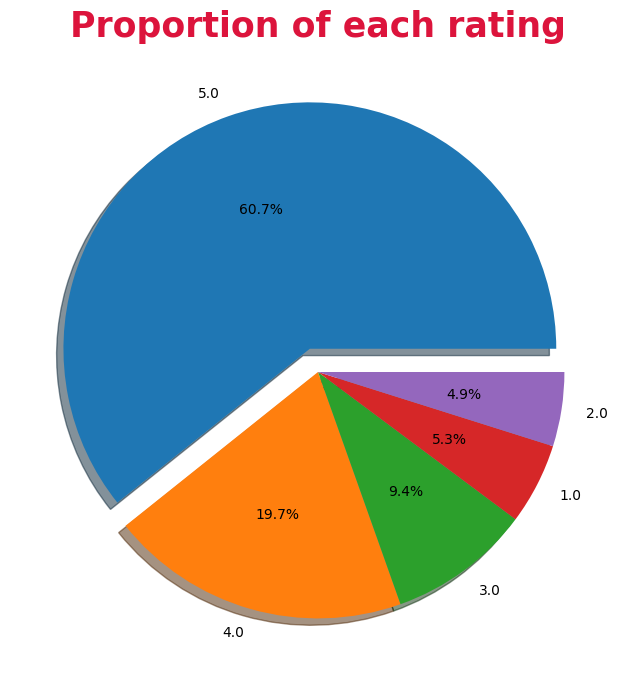

In [13]:
plt.figure(figsize=(15,8))
labels = df['rating'].value_counts().keys()
values = df['rating'].value_counts().values
explode = (0.1,0,0,0,0)
plt.pie(values,labels=labels,explode=explode,shadow=True,autopct='%1.1f%%')
plt.title('Proportion of each rating',fontweight='bold',fontsize=25,pad=20,color='crimson')
plt.show()

 DATA CLEANING AND DATA PREPROCESSING

In [14]:
import re
def remove_punctuations(data):
    punct_tag=re.compile(r'[^\w\s]')
    data=punct_tag.sub(r'',data)
    return data
df['text_']=df['text_'].apply(lambda z: remove_punctuations(z))

In [15]:
def remove_url(data):
    url_clean= re.compile(r"https://\S+|www\.\S+")
    data=url_clean.sub(r'',data)
    return data
df['text_']=df['text_'].apply(lambda z: remove_url(z))

In [16]:
def remove_url(data):
    url_clean= re.compile(r"https://\S+|www\.\S+")
    data=url_clean.sub(r'',data)
    return data
df['text_']=df['text_'].apply(lambda z: remove_url(z))

In [17]:
def remove_emoji(data):
    emoji_clean= re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    data=emoji_clean.sub(r'',data)
    url_clean= re.compile(r"https://\S+|www\.\S+")
    data=url_clean.sub(r'',data)
    return data
df['text_']=df['text_'].apply(lambda z: remove_emoji(z))

In [18]:
def clean_reviews(review):  
    
    # 1. Removing html tags
    review_text = BeautifulSoup(df['text_'],"csv").get_text()
    
    # 2. Retaining only alphabets.
    review_text = re.sub("[^a-zA-Z]"," ",review_text)
    
    # 3. Converting to lower case and splitting
    word_tokens= review_text.lower().split()
    
    # 4. Remove stopwords
    le=WordNetLemmatizer()
    stop_words= set(stopwords.words("english"))     
    word_tokens= [le.lemmatize(w) for w in word_tokens if not w in stop_words]
    
    cleaned_review=" ".join(word_tokens)
    return cleaned_review

FEATURE ENGINEERING

In [19]:
X = df['text_']
y = df['label']

DATA PREPROCESSING ANF MODEL SELECTION

In [20]:
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score


X = df["text_"]
y = df["label"]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0) 

cv = CountVectorizer() 
ctmTr = cv.fit_transform(X_train) 
X_test_dtm = cv.transform(X_test)

model = LogisticRegression() 
model.fit(ctmTr, y_train)

y_pred_class = model.predict(X_test_dtm)
print(accuracy_score(y_test,y_pred_class )*100)

91.03414151410193


In [27]:
print(X_train)

31536    I grew up in a similar situation as this young...
31456    I am one of three sisters who are all avid rea...
26134    Great story I loved both characters The chemis...
12890    Francos acting is great as Gator Statham is St...
16206    These work great for replacement bulbs and are...
                               ...                        
20762    Bags are way too heavy This product should be ...
32112    If you have just a little more experience with...
30412    I feel like i need to go back and read this bo...
21248    Pups love this However first time I have ever ...
2732     Bought these for our daughters room The qualit...
Name: text_, Length: 30315, dtype: object


In [21]:
print(y_pred_class)

['OR' 'CG' 'CG' ... 'CG' 'CG' 'CG']


SAVE MODEL IN PICKLE FILE

In [22]:
import pickle
fake_reviews = 'finalized_model.sav'
pickle.dump(model, open(fake_reviews, 'wb'))

RESULT IN PICKLE FILE

In [23]:
loaded_model = pickle.load(open(fake_reviews, 'rb'))
result = loaded_model.score(X_test_dtm, y_test)
print(result)

0.9103414151410193


In [24]:
from sklearn.metrics import f1_score
f1_score(y_test, y_pred_class, average='macro')

0.9103409506501663

In [25]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
print(precision_score(y_test, y_pred_class, average="macro"))
print(recall_score(y_test, y_pred_class, average="macro"))

0.9103724830395359
0.910353996035816


In [26]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix
cm(y_test, y_pred_class)

array([[4611,  428],
       [ 478, 4588]], dtype=int64)